In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import datetime
from datetime import timedelta
import holidays

In [6]:
# 데이터 불러오기
data = pd.read_csv("./train/train.csv")

#### 파생변수 생성

In [ ]:
# 월(month) -> 계절 매핑 딕셔너리
month_to_season = {
    1: "Winter", 2: "Winter", 12: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Autumn", 10: "Autumn", 11: "Autumn"}

season_weights = {"Winter" : 11.4, "Spring": 6.5, "Summer" : 6.3, "Autumn" : 18.4}

# 월별 가중치 매핑
monthly_weights = {
    1: 2.2, 2: 1.8, 3: 0.3,
    4: 1.01, 5: 0.7, 6: 0.8,
    7: 0.5, 8: 0.5, 9: 0.8,
    10: 1.55, 11: 1.03, 12: 1.4}

# 요일별 가중치 매핑
weekly_weights = {
    "Monday": 0.78, "Tuesday": 0.85, "Wednesday": 0.81,
    "Thursday": 9.9, "Friday": 1.2, "Saturday": 1.53,
    "Sunday": 1.3}

In [8]:
class Make_Variables():
        def __init__(self, data = None, date = None, predict = 7, month_to_season = None, monthly_weights = None, 
                        weekly_weights = None, alpha=1.0, gamma=0.5, unk_menu=1.0):
            self.data = data
            self.date = date
            self.predict = predict
            self.month_to_season = month_to_season
            self.monthly_weights = monthly_weights
            self.weekly_weights = weekly_weights

            self.alpha = alpha
            self.gamma = gamma
            self.unk_menu = unk_menu
            self.menu_cnt_w = None

        def _build_weight(self, series, alpha, gamma, unk):
            """[내부용] 가중치 계산 로직"""
            s = series.astype(float).add(alpha)
            if gamma != 0.0:
                s = s.pow(gamma)
            s = pd.concat([s, pd.Series({"__UNK__": float(unk)})])
            s_sum = s.sum()
            return (s / s_sum).to_dict()
        
        def fit_menu_count_weight(self, df):
            """영업장별 메뉴 가짓수를 기반으로 가중치를 학습(fit)합니다."""
            print("[INFO] 영업장별 메뉴 수 기반 가중치를 학습합니다.")
            # '영업장명', '메뉴명'이 없다면 생성
            if '영업장명' not in df.columns:
                temp_df = df['영업장명_메뉴명'].str.split('_', expand=True)
                df['영업장명'] = temp_df[0]
                df['메뉴명'] = temp_df[1]
                
            cnt = df.groupby("영업장명")["메뉴명"].nunique()
            self.menu_cnt_w = self._build_weight(cnt, self.alpha, self.gamma, self.unk_menu)
        
        def apply_menu_count_weight(self, df):
            """학습된 가중치를 데이터프레임에 적용합니다."""
            if self.menu_cnt_w is None:
                raise RuntimeError("가중치가 학습되지 않았습니다. 먼저 .fit_menu_count_weight(train_df)를 호출하세요.")

            unknown_weight = self.menu_cnt_w.get("__UNK__", 0)
            df['menu_cnt_weight'] = df['영업장명'].map(self.menu_cnt_w).fillna(unknown_weight)
            return df

        def update_kor_holidays(self):
            """국경일 추가"""
            kor_holidays = holidays.KR(years = [2023, 2024, 2025])
            kor_holidays.update({
                datetime.date(2024,10,1) : "Temporary Holiday", # 국군의 날 임시공휴일
                datetime.date(2025,1,27) : "Temporary Holiday", # 설날 임시공휴일
                datetime.date(2025,3,3) : "Temporary Holiday", # 삼일절 대체공휴일
                datetime.date(2025, 6, 3) : "Presidential Election Day"})
            return kor_holidays

        def check_holidays(self, date, kor_holidays) -> int:
            """날짜 받아서 공휴일/주말 여부 출력"""
            # date = pd.Timestamp(date)
            if isinstance(date, pd.Series):
                check_holiday = date.dt.date.isin(kor_holidays)
                check_weekend = date.dt.weekday >= 5
            else:
                check_holiday = date.date() in kor_holidays
                check_weekend = date.weekday() >= 5
            is_holiday = (check_holiday | check_weekend)
            return is_holiday

        def get_sandwich_score(self, data, is_holiday_col) -> pd.DataFrame:
            """데이터프레임 기준으로 샌드위치 점수 계산"""
            data = data.reset_index(drop = True)
            data['is_sandwich'] = 0
            is_holiday = data[is_holiday_col].astype(int)
            for idx in range(len(data)):
                if idx == 0 or idx == len(data) - 1: # 첫날, 마지막 날
                    continue

                # 앞/뒤 하루씩 봤을 때 모두 휴일 -> 5점
                if (is_holiday.iloc[idx - 1] == 1) and (is_holiday.iloc[idx + 1] == 1): # 하루 전이랑 다음 날이 공휴일이면
                    data.iloc[idx, data.columns.get_loc('is_sandwich')] = 5

                # 앞/뒤 이틀씩 봤을 때 휴일 3일 -> 3점, 2일 -> 2점
                elif idx > 1 and idx < len(is_holiday) - 2: # 셋째날, 마지막에서 세 번째 날
                    start_idx = idx - 2
                    end_idx = idx + 2
                    nearby_holidays = (is_holiday.iloc[start_idx : end_idx + 1].sum() - is_holiday.iloc[idx])
                    if nearby_holidays == 3:
                        data.iloc[idx, data.columns.get_loc('is_sandwich')] = 3
                    elif nearby_holidays == 2:
                        data.iloc[idx, data.columns.get_loc('is_sandwich')] = 2
                    else:
                        data.iloc[idx, data.columns.get_loc('is_sandwich')] = 0
            return data

        def get_sandwich_score_for_dates(self, date, kor_holidays) -> int:
            """특정 날짜를 받아와서 앞뒤 날짜를 구하고, 샌드위치 점수 계산"""
            # 하루씩
            prev_date, next_date = date - timedelta(days = 1), date + timedelta(days = 1)
            prev_hol, next_hol = self.check_holidays(prev_date, kor_holidays), self.check_holidays(next_date, kor_holidays) # T/F Bool
            if prev_hol and next_hol: # 바로 다음 날들이 휴일이라면
                return 5
            days_offsets = [-2, -1, 1, 2] # 앞뒤로 이틀 살펴보기
            nearby_holidays = sum(self.check_holidays(date + timedelta(days = d), kor_holidays) for d in days_offsets)
            if nearby_holidays == 3: # 앞뒤 4일 중에 3일이 휴일이면
                return 3
            elif nearby_holidays == 2: # 앞뒤 4일 중에 2일이 휴일이면
                return 2
            else:
                return 0

        def get_season_weights(self, data = None, season_weights = season_weights):
            """계절별 가중치 부여"""
            # 데이터프레임 들어오면
            if data is not None:
                data['season_weight'] = data['season'].map(season_weights)
                return data

        def get_month_weights(self, data = None, monthly_weights = monthly_weights):
            """월별 가중치 부여"""
            # 데이터프레임 들어오면
            if data is not None:
                data['month_weight'] = data['month'].map(monthly_weights)
                return data

        def get_week_weights(self, data = None, weekly_weights = weekly_weights):
            """요일별 가중치 부여"""
            # 데이터프레임 들어오면
            if data is not None:
                data['week_weight'] = data['weekday'].map(weekly_weights)
                return data

        def get_prev_days(self, data, test_df = None, date = None, menu = None, howmany = 7):
            """
            일요일 날짜 받아와서 직전 주차의 일-토 매출수량 평균 계산
            주의 - test data에서 생성할 때는 참고할 데이터와 붙여넣을 데이터가 다름
            data : 참고할 데이터
            test_df : 참고할 데이터
            """
            if test_df is None:
                # 혹시 모르니까 검증
                if date.weekday() == 6:
                    # 이전 날짜들
                    prev_start = date - timedelta(days = howmany)
                    prev_end = date - timedelta(days = 1)
                    prev_data = data[(data['영업일자'] >= prev_start) & (data['영업일자'] <= prev_end) & (data['영업장명_메뉴명'] == menu)]
                    prev_avg = prev_data['매출수량'].mean()
                    prev_sd = prev_data['매출수량'].std()
                    # 첫 주 0으로 처리
                    if pd.isna(prev_avg):
                        prev_avg = 0
                    if pd.isna(prev_sd):
                        prev_sd = 0
                    week_end = date + timedelta(days = 6)
                    curr_mask = (data['영업일자'] >= date) & (data['영업일자'] <= week_end) & (data['영업장명_메뉴명'] == menu)
                    colname_mean = f"prev_avg_{howmany}"
                    colname_sd = f"prev_sd_{howmany}"
                    data.loc[curr_mask, colname_mean] = prev_avg
                    data.loc[curr_mask, colname_sd] = prev_sd
                    return data
                else:
                    return np.nan

            # test data라면
            else:
                # 혹시 모르니까 검증
                if date.weekday() == 6:
                    # 이전 날짜들
                    prev_start = date - timedelta(days = howmany)
                    prev_end = date - timedelta(days = 1)
                    prev_data = test_df[(test_df['영업일자'] >= prev_start) & (test_df['영업일자'] <= prev_end) & (test_df['영업장명_메뉴명'] == menu)]
                    prev_avg = prev_data['매출수량'].mean()
                    prev_sd = prev_data['매출수량'].std()
                    # 첫 주 0으로 처리
                    if pd.isna(prev_avg):
                        prev_avg = 0
                    if pd.isna(prev_sd):
                        prev_sd = 0
                    week_end = date + timedelta(days = 6)
                    curr_mask = (data['영업일자'] >= date) & (data['영업일자'] <= week_end) & (data['영업장명_메뉴명'] == menu)
                    colname_mean = f"prev_avg_{howmany}"
                    colname_sd = f"prev_sd_{howmany}"
                    data.loc[curr_mask, colname_mean] = prev_avg
                    data.loc[curr_mask, colname_sd] = prev_sd
                    return data
                else:
                    return np.nan

        def get_means(self, data, original_data = None):
            # train 단계일 때
            if original_data is None:
                store_avg = data.groupby("영업장명_메뉴명")['매출수량'].mean()
                menu_avg = data.groupby("영업장명")['매출수량'].mean()
                return store_avg, menu_avg
            else:
                merged = pd.concat([data, original_data], axis = 0, ignore_index = True)

                store_avg = merged.groupby("영업장명_메뉴명")['매출수량'].mean()
                menu_avg = merged.groupby("영업장명")['매출수량'].mean()
                return store_avg, menu_avg

        def get_seasonal(self, data, original_data = None):
            if original_data is None:
                # 영업장별
                store_season = (data.groupby(['영업장명', 'season'])['매출수량'].mean().reset_index().rename(columns = {'매출수량' : 'store_season'}))
                data = data.merge(store_season, on = ['영업장명', 'season'], how = 'left')
                data['store_season_ratio'] = data['store_season'] / data['store_avg']

                # 메뉴별
                menu_season = (data.groupby(['영업장명_메뉴명', 'season'])['매출수량'].mean().reset_index().rename(columns = {'매출수량' : 'menu_season'}))
                data = data.merge(menu_season, on = ['영업장명_메뉴명', 'season'], how = 'left')
                data['menu_season_ratio'] = data['menu_season'] / data['menu_avg']

                return data
            else:
                store_season = (original_data.groupby(['영업장명', 'season'])['매출수량'].mean().reset_index().rename(columns = {'매출수량' : 'store_season'}))
                data = data.merge(store_season, on = ['영업장명', 'season'], how = 'left')
                data['store_season_ratio'] = data['store_season'] / data['store_avg']

                # 메뉴별
                menu_season = (original_data.groupby(['영업장명_메뉴명', 'season'])['매출수량'].mean().reset_index().rename(columns = {'매출수량' : 'menu_season'}))
                data = data.merge(menu_season, on = ['영업장명_메뉴명', 'season'], how = 'left')
                data['menu_season_ratio'] = data['menu_season'] / data['menu_avg']

                return data

        # train, test 공통
        def make_fund_variables(self, data, month_to_season = month_to_season):
            # 영업일자 -> datetime
            data['영업일자'] = pd.to_datetime(data['영업일자'])

            # 연, 월, 일, 요일 분리
            data['year'] = data['영업일자'].dt.year
            data['month'] = data['영업일자'].dt.month
            data['day'] = data['영업일자'].dt.day
            data['weekday'] = data['영업일자'].dt.day_name()
            data['weekday_enc'] = data['영업일자'].dt.weekday

            # 계절 변수 생성
            data['season'] = data['month'].map(month_to_season)

            # 연도 차이 변수 생성
            data['year_enc'] = data['year'] - 2023

            # 월, 일, 요일 사이클릭 변환
            data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
            data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

            data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
            data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

            data['weekday_sin'] = np.sin(2 * np.pi * data['weekday_enc'] / 7)
            data['weekday_cos'] = np.cos(2 * np.pi * data['weekday_enc'] / 7)

            day_of_year = data["영업일자"].dt.dayofyear
            data['year_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
            data['year_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

            # 공휴일 확인
            kor_holidays = self.update_kor_holidays()
            check_holiday = data['영업일자'].dt.date.isin(kor_holidays)
            check_weekend = data['weekday'].isin(['Saturday', 'Sunday'])
            data['is_holiday'] = (check_holiday | check_weekend).astype(int) # 공휴일 + 주말
            data['holiday_name'] = data['영업일자'].dt.date.map(kor_holidays)

            ### 영업장명, 메뉴명 분리
            if '영업장명_메뉴명' in data.columns:
                data[['영업장명', '메뉴명']] = data['영업장명_메뉴명'].str.split('_', expand = True)

            ### 단체 변수
            group_words = ["단체", "6인석", "12인석", "2인", "4인", "3인"]
            mask = data['메뉴명'].astype(str).apply(lambda x : any(k in x for k in group_words))
            data['group'] = mask.astype(int)

            return data

        # train의 입력 데이터 + lookback 28일 데이터
        def make_variables_train(self, data):
            data = self.make_fund_variables(data)
            kor_holidays = self.update_kor_holidays()

            ### 샌드위치 데이
            data = self.get_sandwich_score(data, 'is_holiday')

            # 샌드위치 - 첫날
            first = data['영업일자'].min()
            data.loc[data['영업일자'] == first, 'is_sandwich'] = self.get_sandwich_score_for_dates(first, kor_holidays)
            second = data['영업일자'].min() + timedelta(days = 1)
            data.loc[data['영업일자'] == second, 'is_sandwich'] = self.get_sandwich_score_for_dates(second, kor_holidays)

            # 샌드위치 - 마지막 날
            last = data['영업일자'].max()
            data.loc[data['영업일자'] == last, 'is_sandwich'] = self.get_sandwich_score_for_dates(last, kor_holidays)
            before = data['영업일자'].max() - timedelta(days = 1)
            data.loc[data['영업일자'] == before, 'is_sandwich'] = self.get_sandwich_score_for_dates(before, kor_holidays)

            # 서브웨이 샌드위치 포함한 공휴일
            data['is_holiday_sandwich'] = data['is_holiday'].astype(int) | (data['is_sandwich'] > 0).astype(int)

            ### 계절별 가중치
            data = self.get_season_weights(data, season_weights)

            ### 월별 가중치
            data = self.get_month_weights(data, monthly_weights)

            ### 요일별 가중치
            data = self.get_week_weights(data, weekly_weights)

            ### 직전 주차 평균
            sundays = data[data['weekday'] == "Sunday"][["영업일자", "영업장명_메뉴명"]].copy()
            for _, row in sundays.iterrows():
                date = row['영업일자']
                menu = row['영업장명_메뉴명']
                data = self.get_prev_days(data = data, date = date, menu = menu, howmany = 7)
                data = self.get_prev_days(data = data, date = date, menu = menu, howmany = 14)
                data = self.get_prev_days(data = data, date = date, menu = menu, howmany = 21)

            ### 음수 처리
            negative = data[data['매출수량'] < 0]

            for idx, row in negative.iterrows():
                num = row['매출수량']
                if num < -10:
                    date = row['영업일자']
                    menu = row['영업장명_메뉴명']
                    prev_date = pd.to_datetime(date) - pd.Timedelta(days = 1)
                    prev_row = data[(data['영업일자'] == prev_date) & (data['영업장명_메뉴명'] == menu)]

                    if prev_row.iloc[0]["매출수량"] >= abs(num):
                        data.loc[prev_row.index[0], '매출수량'] += num

            # 남은 건 전부 0으로
            data.loc[data['매출수량'] < 0, '매출수량'] = 0

            # 평균 매핑 - data에 test_df 들어가고, original_data에 기존 train에 사용한 데이터 넣기
            store_avg, menu_avg = self.get_means(data, original_data = None)
            data['store_avg'] = data['영업장명_메뉴명'].map(store_avg)
            data['menu_avg'] = data['영업장명'].map(menu_avg)

            ### 계절 영향 추가
            data = self.get_seasonal(data)

            return data

        # 예측하고자 하는 날들
        def make_variables_test(self, date, test_df, original_data = None, predict = 7):
            """
            date : 최종 날짜 (입력 7일 중 가장 마지막) - TimeStamp
            test_df : 예측할 때 참고해올 데이터 -> 이거로 직전 주차 평균 생성
            original_data -> train에 사용한 데이터 (data로 저장)
            """
            date = pd.to_datetime(date)
            future_dates = [date + timedelta(days = i + 1) for i in range(predict)]
            future_df = pd.DataFrame({'영업일자' : future_dates})

            menus_df = (test_df[['영업장명_메뉴명']].drop_duplicates().reset_index(drop = True))
            future_df = future_df.merge(menus_df, how='cross')

            kor_holidays = self.update_kor_holidays()

            # 기본적인 변수들
            future_df = self.make_fund_variables(future_df)

            future_df['영업일자'] = pd.to_datetime(future_df['영업일자']).dt.normalize()

            # 샌드위치
            future_df['is_sandwich'] = future_df['영업일자'].apply(lambda d: self.get_sandwich_score_for_dates(d, kor_holidays))

            # 샌드위치 포함한 공휴일
            future_df['is_holiday_sandwich'] = future_df['is_holiday'].astype(int) | (future_df['is_sandwich'] > 0).astype(int)

            ### 계절별 가중치
            future_df = self.get_season_weights(future_df, season_weights)

            # 월별 가중치
            future_df = self.get_month_weights(future_df, monthly_weights)

            # 요일별 가중치
            future_df = self.get_week_weights(future_df, weekly_weights)

            # 직전 주차 평균 -> 이거는 test 까지 받아오고 생각해야 함..
            sundays =  future_df.loc[future_df['weekday'] == "Sunday", ['영업일자', '영업장명_메뉴명']].copy()
            for _, row in sundays.iterrows():
                date = row['영업일자']
                menu = row['영업장명_메뉴명']
                future_df = self.get_prev_days(data = future_df, test_df = test_df, date = date, menu = menu, howmany = 7)
                future_df = self.get_prev_days(data = future_df, test_df = test_df, date = date, menu = menu, howmany = 14)
                future_df = self.get_prev_days(data = future_df, test_df = test_df, date = date, menu = menu, howmany = 21)

            # 앞서 계산한 값들로 매핑
            store_avg, menu_avg = self.get_means(future_df, original_data = original_data)
            future_df['store_avg'] = future_df['영업장명_메뉴명'].map(store_avg)
            future_df['menu_avg'] = future_df['영업장명'].map(menu_avg)

            ### 계절 영향 추가
            future_df = self.get_seasonal(future_df, original_data = original_data)

            return future_df

In [ ]:
# 전체 전처리 실행
mv = Make_Variables()
data = mv.make_variables_train(data = data)

In [10]:
data.columns

Index(['영업일자', '영업장명_메뉴명', '매출수량', 'year', 'month', 'day', 'weekday',
       'weekday_enc', 'season', 'year_enc', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'year_sin',
       'year_cos', 'is_holiday', 'holiday_name', '영업장명', '메뉴명', 'group',
       'is_sandwich', 'is_holiday_sandwich', 'season_weight', 'month_weight',
       'week_weight', 'prev_avg_7', 'prev_sd_7', 'prev_avg_14', 'prev_sd_14',
       'prev_avg_21', 'prev_sd_21', 'store_avg', 'menu_avg', 'store_season',
       'store_season_ratio', 'menu_season', 'menu_season_ratio'],
      dtype='object')

In [ ]:
# 전처리 완료 후 pickle 저장
import pickle
data.to_pickle("./train_data_final.pickle")

#### 저장된 데이터 불러오기

In [ ]:
# pickle 불러오기
import pickle
data = pd.read_pickle("./train_data_final.pickle")

#### XGBoost

In [172]:
df_processed = data
df_processed.fillna(0, inplace=True)
print("기본 피처 생성 완료")

# 추가 피처 생성 (is_signature, is_essential)
# is_signature 생성
sales_sum = df_processed.groupby('영업장명_메뉴명')['매출수량'].sum()
signature_menus = sales_sum[sales_sum >= 10000].index.tolist()
df_processed['is_signature'] = df_processed['영업장명_메뉴명'].isin(signature_menus).astype(int)
print(f"시그니처 메뉴 피처 생성 완료: 총 {len(signature_menus)}개")

# is_essential 생성
damha_non_essential = [
    '(후식) 된장찌개', '메밀면 사리', '참이슬', '카스', '(후식) 물냉면', '테라',
    '느린마을 막걸리', '콜라', '스프라이트', '라면사리', '갱시기',
    '(후식) 비빔냉면', '처음처럼', '더덕 한우 지짐', '하동 매실 칵테일',
    '제로콜라', '(단체) 공깃밥', '룸 이용료', '문막 복분자 칵테일', '명인안동소주'
]
mirasia_non_essential = [
    '버드와이저(무제한)', '애플망고 에이드','스텔라(무제한)', '코카콜라',
    '핑크레몬에이드', '얼그레이 하이볼', 'BBQ 고기추가', '스프라이트',
    '유자 하이볼', '코카콜라(제로)', '콥 샐러드', '칠리 치즈 프라이',
    '레인보우칵테일(알코올)', '파스타면 추가(150g)', '공깃밥',
    '글라스와인 (레드)', '잭 애플 토닉'
]
banquet_non_essential = [
   '삼겹살추가 (200g)', 'Convention Hall', '마라샹궈', 'Grand Ballroom', '야채추가',
    'Conference L1', 'Conference M1', 'Conference L3', 'Conference L2',
    'OPUS 2', 'Conference M9', 'Conference M8'
]

def create_is_essential(row):
    store = row['영업장명']
    menu = row['메뉴명']

    if store == '담하':
        return 0 if menu in damha_non_essential else 1
    elif store == '미라시아':
        return 0 if menu in mirasia_non_essential else 1
    elif store == '연회장':
        # 연회장 메뉴 이름에서 콜론 뒷부분을 제거하고 비교
        cleaned_menu = menu.split(':')[0].strip()
        return 0 if cleaned_menu in banquet_non_essential else 1
    elif store == '카페테리아':
        return 0 if menu == '샷 추가' else 1
    else:
        return 1

df_processed['is_essential'] = df_processed.apply(create_is_essential, axis=1)
print("--- 'is_essential' 피처 생성 규칙 검증 ---")


# --- 검증 로직 ---
expected_zero_counts = {
    '담하': len(damha_non_essential),
    '미라시아': len(mirasia_non_essential),
    '연회장': len(banquet_non_essential),
    '카페테리아': 1,
}

results = []
all_stores = sorted(df_processed['영업장명'].unique())

for store_name in all_stores:
    store_df = df_processed[df_processed['영업장명'] == store_name]
    total_menus_in_data = store_df['메뉴명'].nunique()
    actual_zero_count = store_df[store_df['is_essential'] == 0]['메뉴명'].nunique()
    actual_one_count = store_df[store_df['is_essential'] == 1]['메뉴명'].nunique()
    expected_zeros = expected_zero_counts.get(store_name, 0)
    is_correct = (actual_zero_count == expected_zeros)

    results.append({
        '영업장명': store_name,
        '총 메뉴 수': total_menus_in_data,
        "'제외 메뉴'(0) 실제 개수": actual_zero_count,
        "'제외 메뉴'(0) 예상 개수": expected_zeros,
        "'필수 메뉴'(1) 실제 개수": actual_one_count,
        '규칙 일치 여부': ' 일치' if is_correct else ' 불일치'
    })

verification_df = pd.DataFrame(results)
print(verification_df.to_string())

기본 피처 생성 완료
시그니처 메뉴 피처 생성 완료: 총 40개
--- 'is_essential' 피처 생성 규칙 검증 ---
         영업장명  총 메뉴 수  '제외 메뉴'(0) 실제 개수  '제외 메뉴'(0) 예상 개수  '필수 메뉴'(1) 실제 개수 규칙 일치 여부
0  느티나무 셀프BBQ      23                 0                 0                23       일치
1          담하      42                20                20                22       일치
2        라그로타      25                 0                 0                25       일치
3        미라시아      31                17                17                14       일치
4         연회장      23                12                12                11       일치
5       카페테리아      24                 1                 1                23       일치
6       포레스트릿      12                 0                 0                12       일치
7       화담숲주막       8                 0                 0                 8       일치
8       화담숲카페       5                 0                 0                 5       일치


In [173]:
signature_df = df_processed[df_processed['is_signature'] == 1].copy()

# 영업장명으로 그룹화한 뒤, 각 그룹의 고유한 메뉴명 개수를 계산
signature_counts_by_store = signature_df.groupby('영업장명')['메뉴명'].nunique()

# 결과 출력
print("--- 영업장별 시그니처 메뉴 개수 ---")
print(signature_counts_by_store)

--- 영업장별 시그니처 메뉴 개수 ---
영업장명
느티나무 셀프BBQ     3
담하             3
미라시아           4
카페테리아         10
포레스트릿         10
화담숲주막          6
화담숲카페          4
Name: 메뉴명, dtype: int64


In [174]:
signature_menus_by_store = signature_df.groupby('영업장명')['메뉴명'].apply(lambda x: x.unique().tolist())
print("--- 영업장별 시그니처 메뉴 목록 ---")
print(signature_menus_by_store)

--- 영업장별 시그니처 메뉴 목록 ---
영업장명
느티나무 셀프BBQ                      [BBQ55(단체), 참이슬 (단체), 카스 병(단체)]
담하                          [(단체) 황태해장국 3/27까지, 공깃밥, 담하 한우 불고기]
미라시아          [(단체)브런치주중 36,000, 미라시아 브런치 (패키지), 브런치(대인) 주말,...
카페테리아         [공깃밥(추가), 단체식 13000(신), 단체식 18000(신), 돼지고기 김치찌...
포레스트릿         [꼬치어묵, 떡볶이, 복숭아 아이스티, 생수, 스프라이트, 아메리카노(HOT), 아...
화담숲주막                 [느린마을 막걸리, 병천순대, 참살이 막걸리, 찹쌀식혜, 콜라, 해물파전]
화담숲카페                    [메밀미숫가루, 아메리카노 HOT, 아메리카노 ICE, 현미뻥스크림]
Name: 메뉴명, dtype: object


In [175]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

[INFO] 영업장별 메뉴 수 기반 가중치를 학습합니다.
학습 feautre 숫자:52
학습 features: ['month', 'day', 'weekday_enc', 'month_sin', 'month_cos', 'day_cos', 'weekday_sin', 'year_sin', 'year_cos', 'is_holiday', '영업장명', '메뉴명', 'group', 'is_sandwich', 'season_weight', 'month_weight', 'prev_avg_7', 'prev_sd_7', 'prev_avg_14', 'prev_sd_14', 'prev_avg_21', 'prev_sd_21', 'store_avg', 'menu_avg', 'store_season', 'store_season_ratio', 'menu_season', 'menu_season_ratio', 'is_signature', 'is_essential', 'volatility_holiday_interaction', 'holiday_tomorrow', 'holiday_yesterday', 'consecutive_holidays', 'volatility_score_14d', 'volatility_score_21d', 'month_position', 'holiday_cluster_effect', 'menu_weight_volatility', 'ratio_avg_7_14', 'ratio_avg_7_21', 'accel_avg', 'rel_sd_7', 'rel_sd_14', 'rel_sd_21', 'hol_prev7', 'sand_prev7', 'hol_weekw', 'sand_weekw', 'non_menu', 'more_2', 'more_6']
--- 4) 기존 + is_signature + is_essential 모델 실행 ---

 최종 Validation SMAPE: 0.5130
   (최적 나무 개수: 1090)


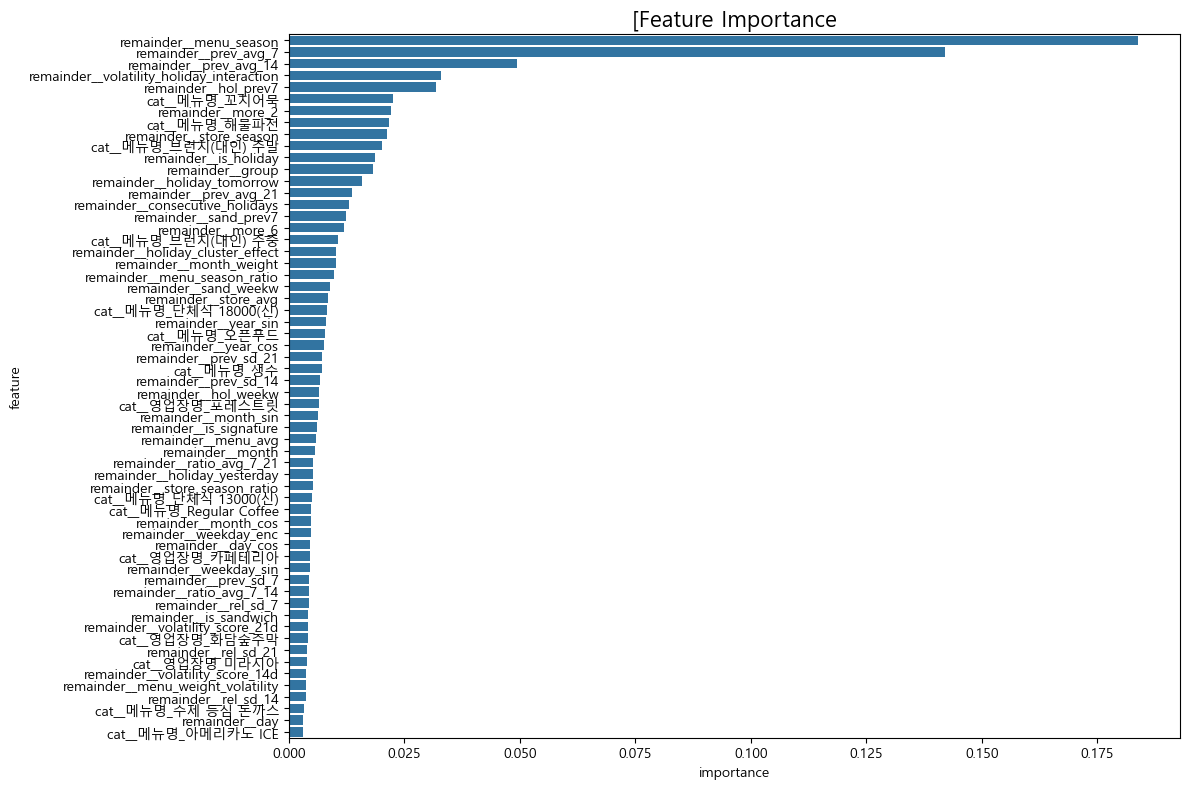

In [ ]:
def smape(y_true, y_pred):
    non_zero_mask = y_true != 0
    y_true_masked = y_true[non_zero_mask]
    y_pred_masked = y_pred[non_zero_mask]
    numerator = np.abs(y_pred_masked - y_true_masked)
    denominator = (np.abs(y_true_masked) + np.abs(y_pred_masked)) / 2
    return np.mean(numerator / denominator)

df_processed['영업일자'] = pd.to_datetime(df_processed['영업일자'])
mv.fit_menu_count_weight(df_processed)
df_processed = mv.apply_menu_count_weight(df_processed)

def add_feature(df,eps=1e-8):
    df["volatility_holiday_interaction"] = df['prev_sd_7'] * df["is_holiday"] # 확인

    df = df.sort_values(['영업장명_메뉴명', '영업일자']).reset_index(drop=True)
    df['holiday_tomorrow'] = df.groupby('영업장명_메뉴명')['is_holiday'].shift(-1).fillna(0)
    df['holiday_yesterday'] = df.groupby('영업장명_메뉴명')['is_holiday'].shift(1).fillna(0)

    df['consecutive_holidays'] = df.groupby('영업장명_메뉴명')['is_holiday'].apply(
        lambda x: x.groupby((x != x.shift()).cumsum()).transform('sum') * x
    ).values

    df['volatility_score_7d'] = df['prev_sd_7'] / (df['prev_avg_7'] + eps)
    df['volatility_score_14d'] = df['prev_sd_14'] / (df['prev_avg_14'] + eps)
    df['volatility_score_21d'] = df['prev_sd_21'] / (df['prev_avg_21'] + eps)

    df['month_position'] = df['day'] / 31.0
    
    df['holiday_cluster_effect'] = (df['is_holiday'] + df['holiday_tomorrow'] + 
                                   df['holiday_yesterday'] + df['is_sandwich']) * df['week_weight']
    df['menu_weight_volatility'] = df['menu_cnt_weight'] * df['volatility_score_7d']

    df["ratio_avg_7_14"] = df.get("prev_avg_7", 0) / (df.get("prev_avg_14", 0) + eps)
    df["ratio_avg_7_21"] = df.get("prev_avg_7", 0) / (df.get("prev_avg_21", 0) + eps)
    # # # 가속도(7-14 변화에서 14-21 변화 빼기)
    df["accel_avg"] = (df.get("prev_avg_7", 0) - df.get("prev_avg_14", 0)) - \
                    (df.get("prev_avg_14", 0) - df.get("prev_avg_21", 0))
    df["rel_sd_7"]  = df.get("prev_sd_7", 0)  / (df.get("prev_avg_7", 0)  + eps)
    df["rel_sd_14"] = df.get("prev_sd_14", 0) / (df.get("prev_avg_14", 0) + eps)
    df["rel_sd_21"] = df.get("prev_sd_21", 0) / (df.get("prev_avg_21", 0) + eps)

    df["hol_prev7"]   = df.get("is_holiday", 0) * df.get("prev_avg_7", 0)
    df["sand_prev7"]  = df.get("is_holiday_sandwich", 0) * df.get("prev_avg_7", 0)
    df["hol_weekw"]   = df.get("is_holiday", 0) * df.get("week_weight", 0)
    df["sand_weekw"]  = df.get("is_holiday_sandwich", 0) * df.get("week_weight", 0)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col] = df[col].replace([np.inf, -np.inf], 0)
        df[col] = df[col].fillna(0)
    return df

df_processed = add_feature(df_processed)

bbq_non_menu = [
    '잔디그늘집 대여료 (6인석)', '1인 수저세트', '대여료 30,000원', '대여료 60,000원', 
    '잔디그늘집 대여료 (12인석)', '친환경 접시 23cm', '일회용 종이컵', 
    '잔디그늘집 의자 추가', '친환경 접시 14cm', '대여료 90,000원'
]

damha_non_menu = ['룸 이용료']
banquet_non_menu = [
    'Convention Hall', 'Grand Ballroom', 'Conference L1', 'Conference M1', 
    'Conference L3', 'Conference L2', 'OPUS', 'Conference M9', 'Conference M8'
]

def create_non_menu(row):
    store = row['영업장명']
    menu = row['메뉴명']
    
    if store == '느티나무 셀프BBQ':
        return 1 if menu in bbq_non_menu else 0
    elif store == '담하':
        return 1 if menu in damha_non_menu else 0
    elif store == '연회장':
        return 1 if any(non_menu_item in menu for non_menu_item in banquet_non_menu) else 0
    else:
        return 0

df_processed['non_menu'] = df_processed.apply(create_non_menu, axis=1)

more_2_keywords = ['6인', '12인', '단체', '단체식', '플래터', '패키지', 'conference', 'Ballroom', 'Hall', '2인', '3인']
more_6_keywords = ['6인', '12인', '단체', '단체식', 'conference', 'Ballroom', 'Hall']

more_2_pattern = '|'.join(more_2_keywords)
more_6_pattern = '|'.join(more_6_keywords)

df_processed['more_2'] = df_processed['영업장명_메뉴명'].str.contains(more_2_pattern, case=False, na=False).astype(int)
df_processed['more_6'] = df_processed['영업장명_메뉴명'].str.contains(more_6_pattern, case=False, na=False).astype(int)

train_cutoff = df_processed['영업일자'].max() - pd.DateOffset(days=30)
train_df = df_processed[df_processed['영업일자'] <= train_cutoff].copy()
val_df = df_processed[df_processed['영업일자'] > train_cutoff].copy()

# 4번 시나리오에 해당하는 피처 목록 정의
features = [col for col in df_processed.columns if col not in [
    '영업일자', '영업장명_메뉴명', '매출수량', 'weekday',
    'holiday_name', 'season',"menu_cnt_weight",
    'year','week_weight','is_holiday_sandwich',"volatility_score_7d",
    "weekday_cos","day_sin", 'year_enc',"day"
]]
print(f"학습 feautre 숫자:{len(features)}\n학습 features: {features}")
enc_cols = ['영업장명', '메뉴명']

X_train = train_df[features]
y_train = train_df['매출수량']
X_val = val_df[features]
y_val = val_df['매출수량']

# --- 2. 전처리기 및 모델 학습 ---
print("--- 4) 기존 + is_signature + is_essential 모델 실행 ---")

# 전처리기
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), enc_cols)],
    remainder='passthrough'
)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# XGBoost 파라미터
params = {'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'rmse',
        'n_estimators': 2448,
        'learning_rate': 0.006188076963806668,
        'max_depth': 12,
        'min_child_weight': 1.160504899256206,
        'subsample': 0.891285745692046,
        'colsample_bytree': 0.6416710602253682,
        'reg_alpha': 1.0066631755246014,
        'reg_lambda': 0.5390616496613874,
        'gamma': 0.9497142061345805,
        'early_stopping_rounds': 30,
        'tree_method': 'hist'}

# 모델 학습
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    verbose=False
)

# --- 3. 예측 및 최종 SMAPE 점수 출력 ---
best_iteration = xgb_model.best_iteration
predictions = xgb_model.predict(X_val_processed, iteration_range=(0,best_iteration))
predictions = np.round(np.maximum(0, predictions))
predictions[predictions == 0] = 1

smape_score = smape(y_val, predictions)

print(f"\n 최종 Validation SMAPE: {smape_score:.4f}")
print(f"   (최적 나무 개수: {best_iteration})")
importances = pd.DataFrame({
            'feature': preprocessor.get_feature_names_out(),
            'importance': xgb_model.feature_importances_
            }).sort_values('importance', ascending=False).head(60)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances)
plt.title(f'[Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# 사용할 피처 및 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), enc_cols)
    ],
    remainder='passthrough'
)

#  전체 데이터로 최종 모델 학습 및 저장
X_full = df_processed[features]
y_full = df_processed['매출수량']

print("최종 모델 학습 시작...")
X_full_processed = preprocessor.fit_transform(X_full)

all_params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'rmse',
        'n_estimators': best_iteration,
        'learning_rate': 0.006188076963806668,
        'max_depth': 12,
        'min_child_weight': 1.160504899256206,
        'subsample': 0.891285745692046,
        'colsample_bytree': 0.6416710602253682,
        'reg_alpha': 1.0066631755246014,
        'reg_lambda': 0.5390616496613874,
        'gamma': 0.9497142061345805,
        'tree_method': 'hist'
    }

# 가장 성능이 좋았던 파라미터로 최종 모델 정의
final_model = xgb.XGBRegressor(**all_params)
final_model.fit(X_full_processed, y_full)

joblib.dump(final_model, './final_xgb_model2.pkl') ################################
joblib.dump(preprocessor, './final_xgb_preprocessor2.pkl') ################################

print("\n최종 모델과 전처리기 저장 완료")

최종 모델 학습 시작...

최종 모델과 전처리기 저장 완료


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import glob
import os
import re

# --- 1. 저장된 모델, 전처리기, 데이터 로드 ---
model = joblib.load('./final_xgb_model2.pkl') ################################
preprocessor = joblib.load('./final_xgb_preprocessor2.pkl') ################################
sample_submission = pd.read_csv('./sample_submission.csv') ################################
train_df_for_rules = data
print("모델 및 전처리기 로드 완료")

# --- 2. 예측에 필요한 규칙/정보 사전 계산 ---
sales_sum = train_df_for_rules.groupby('영업장명_메뉴명')['매출수량'].sum()
signature_menus = sales_sum[sales_sum >= 10000].index.tolist()
features_to_use = preprocessor.feature_names_in_

# --- 3. 테스트 파일 순회하며 예측 수행 ---
all_predictions_long = []
test_files = sorted(glob.glob('./test/TEST_*.csv'))
print(f"\n{len(test_files)}개 테스트 파일 예측 시작...")

for path in test_files:
    test_df = pd.read_csv(path)
    test_df['영업일자'] = pd.to_datetime(test_df['영업일자'])

    filename = os.path.basename(path)
    test_prefix = re.search(r'(TEST_\d+)', filename).group(1)

    # 기본 피처 및 추가 피처 생성
    last_date = test_df['영업일자'].max()
    future_df_full = mv.make_variables_test(date=last_date, test_df=test_df, original_data = df_processed, predict=7)
    future_df_full.fillna(0, inplace=True)
    future_df_full['is_signature'] = future_df_full['영업장명_메뉴명'].isin(signature_menus).astype(int)
    future_df_full['is_essential'] = future_df_full.apply(create_is_essential, axis=1)
    future_df_full = mv.apply_menu_count_weight(future_df_full)
    future_df_full = add_feature(future_df_full)
    future_df_full['non_menu'] = future_df_full.apply(create_non_menu, axis=1)
    future_df_full['more_2'] = future_df_full['영업장명_메뉴명'].str.contains(more_2_pattern, case=False, na=False).astype(int)
    future_df_full['more_6'] = future_df_full['영업장명_메뉴명'].str.contains(more_6_pattern, case=False, na=False).astype(int)
    for menu, menu_future_df in future_df_full.groupby('영업장명_메뉴명'):

        X_test = menu_future_df[features_to_use]
        X_test_processed = preprocessor.transform(X_test)
        predictions = model.predict(X_test_processed)

        # 후처리
        predictions = np.maximum(0, predictions)
        predictions = np.round(predictions)
        predictions[predictions == 0] = 1

        # 결과 저장
        pred_dates = [f"{test_prefix}+{i+1}일" for i in range(7)]
        result_df = pd.DataFrame({
            '영업일자': pred_dates,
            '영업장명_메뉴명': menu,
            '매출수량': predictions
        })
        all_predictions_long.append(result_df)

    print(f" - {filename} 예측 완료.")

def convert_to_submission_format(pred_df: pd.DataFrame, sample_submission: pd.DataFrame):
    pred_dict = dict(zip(zip(pred_df['영업일자'], pred_df['영업장명_메뉴명']), pred_df['매출수량']))
    final_df = sample_submission.copy()
    menu_cols = final_df.columns[1:]
    final_df[menu_cols] = final_df[menu_cols].astype(float)

    for row_idx in final_df.index:
        date = final_df.loc[row_idx, '영업일자']
        for col in menu_cols:
            final_df.loc[row_idx, col] = pred_dict.get((date, col), 0) # 예측값이 없으면 0으로 채움
    return final_df

# --- 4. 최종 제출 파일 생성 ---
final_pred_df_long = pd.concat(all_predictions_long, ignore_index=True)
submission_df5 = convert_to_submission_format(final_pred_df_long, sample_submission)
submission_df5.to_csv('submission5.csv', index=False)

print("\n예측 완료. 'submission5.csv' 파일이 생성되었습니다.")
print("제출 파일 미리보기:")
print(submission_df5.head())

모델 및 전처리기 로드 완료

10개 테스트 파일 예측 시작...
 - TEST_00.csv 예측 완료.
 - TEST_01.csv 예측 완료.
 - TEST_02.csv 예측 완료.
 - TEST_03.csv 예측 완료.
 - TEST_04.csv 예측 완료.
 - TEST_05.csv 예측 완료.
 - TEST_06.csv 예측 완료.
 - TEST_07.csv 예측 완료.
 - TEST_08.csv 예측 완료.
 - TEST_09.csv 예측 완료.

예측 완료. 'submission5.csv' 파일이 생성되었습니다.
제출 파일 미리보기:
         영업일자  느티나무 셀프BBQ_1인 수저세트  느티나무 셀프BBQ_BBQ55(단체)  \
0  TEST_00+1일                10.0                  27.0   
1  TEST_00+2일                 4.0                  50.0   
2  TEST_00+3일                 4.0                  65.0   
3  TEST_00+4일                 4.0                  49.0   
4  TEST_00+5일                 5.0                  66.0   

   느티나무 셀프BBQ_대여료 30,000원  느티나무 셀프BBQ_대여료 60,000원  느티나무 셀프BBQ_대여료 90,000원  \
0                     6.0                     3.0                     1.0   
1                     2.0                     1.0                     1.0   
2                     2.0                     1.0                     1.0   
3                     2.0    